In this notebook I will show you how to read in <a href="http://www.crowdflower.com/" target="_blank">Crowdflower</a> data into both MongoDB and PANDAS. I base this example off a recent crowdsourced coding project in which Crowdflower coders coded the sentiment in a sample of 1,000 tweets. 

## Import packages and set viewing options

As per normal, we will first import several necessary Python packages and set some options for viewing the data. As with prior chapters, we will be using the <a href="http://pandas.pydata.org/">Python Data Analysis Library,</a> or <i>PANDAS</i>, extensively for our data manipulations.

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
import json

In [3]:
#http://pandas.pydata.org/pandas-docs/stable/options.html
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 250)

I'm using version 0.17.1 of PANDAS

In [4]:
pd.__version__

u'0.17.1'

#### Import graphing packages

We'll be producing some figures in this tutorial so we need to import various graphing capabilities. The default Matplotlib library is solid. 

In [5]:
import matplotlib
print matplotlib.__version__

1.5.0


In [6]:
import matplotlib.pyplot as plt

In [7]:
#NECESSARY FOR XTICKS OPTION, ETC.
from pylab import*

One of the great innovations of ipython notebook is the ability to see output and graphics "inline," that is, on the same page and immediately below each line of code. To enable this feature for graphics we run the following line.

In [46]:
%matplotlib inline  

We will be using <i>Seaborn</i> to help pretty up the default Matplotlib graphics. Seaborn does not come installed with Anaconda Python so you will have to open up a terminal and run <i>pip install seaborn</i>.


In [26]:
import seaborn as sns
print sns.__version__

0.6.0


<br>The following line will set the default plots to be bigger.

In [10]:
plt.rcParams['figure.figsize'] = (15, 5)

### MongoDB

To use MongoDB you'll have to have it set up and installed on your system. There are some good tutorials out there. Once it's installed open up a terminal and start MongoDB. On my Mac I simply run the command *mongod* in the Terminal.

In [11]:
import pymongo
from pymongo import MongoClient
client = MongoClient()

In [12]:
# DEFINE a mongoDB DATABASE
db = client['crowdflower_data']

# DEFINE A COLLECTION (TABLE) WHERE YOU'LL INSERT THE DATA 
codes = db['codes']

### Read in JSON file

Crowdflower will give you a JSON file containing the crowdsourced codes. First we'll load this file. This file has 1,056 rows -- one for each of the 1,000 tweets I uploaded to Crowdflower and 56 for the rows I coded myself as a training dataset. The image below shows a sample of the JSON file you'll get from Crowdflower.

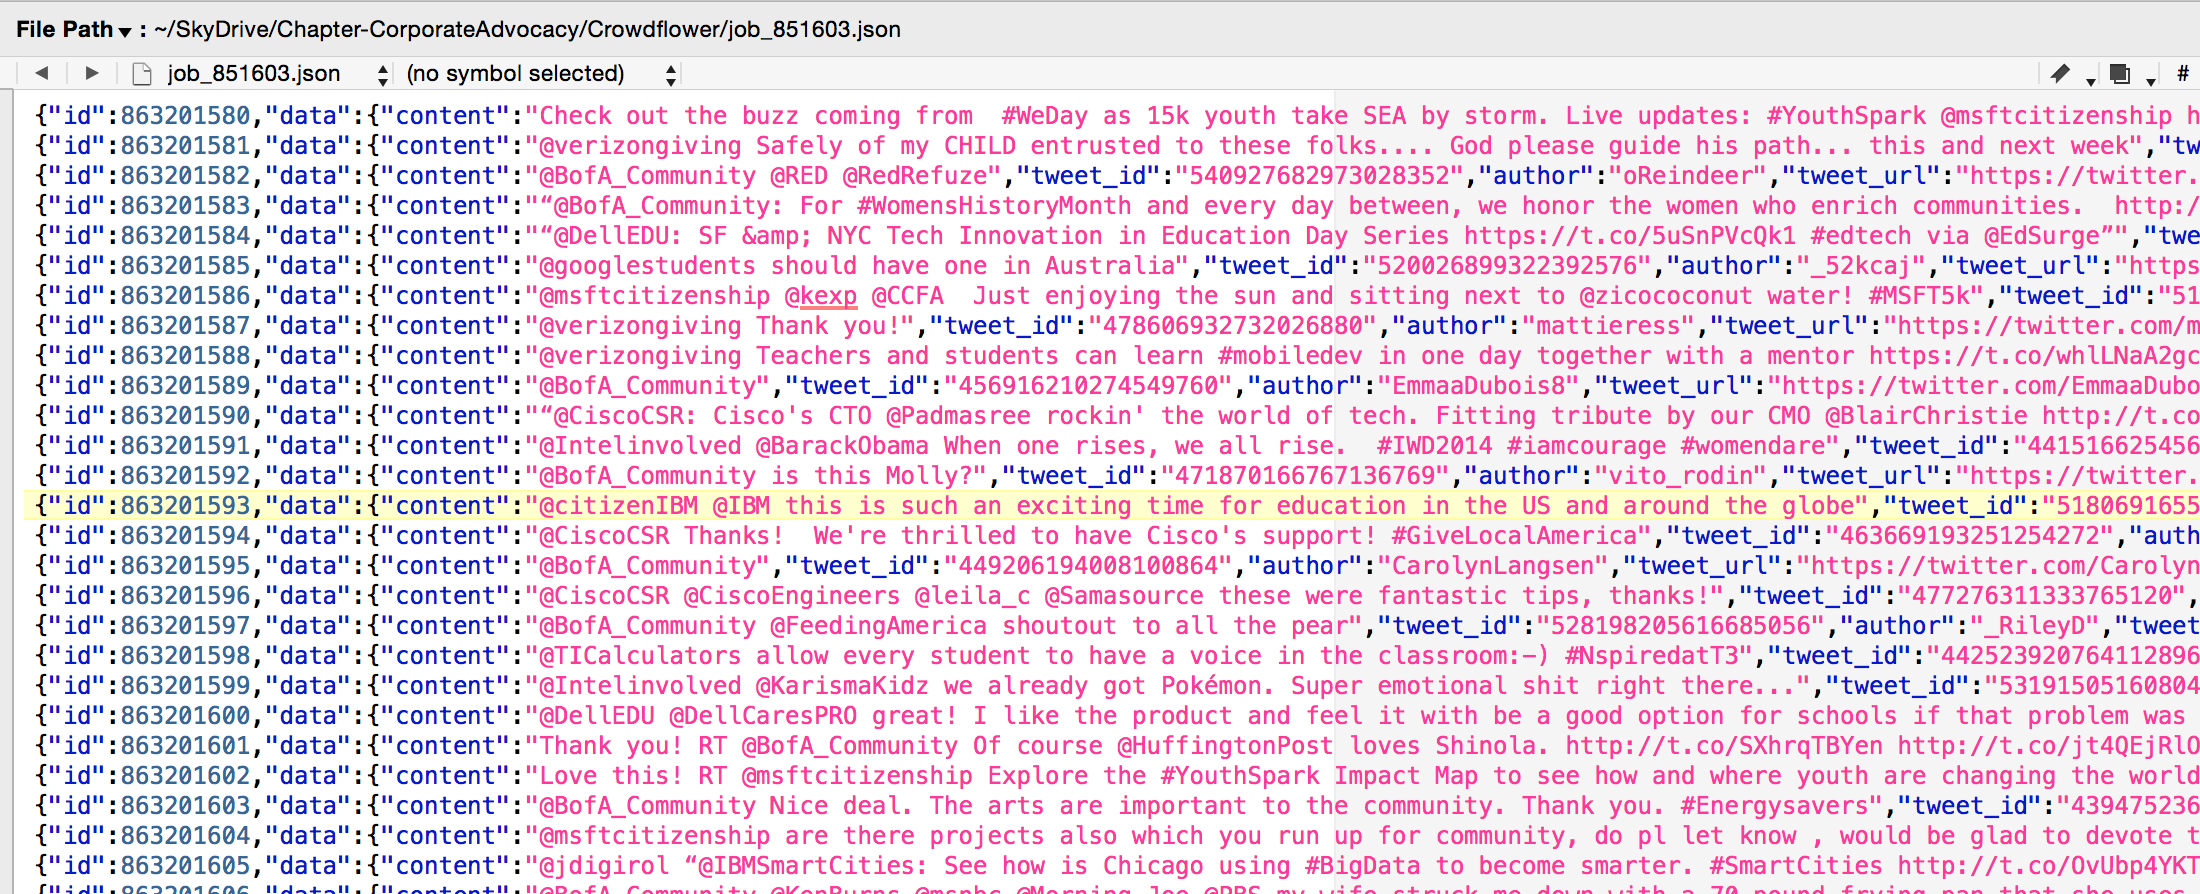

In [13]:
from IPython.display import Image
Image(width=900, filename='Crowdflower JSON.png')

In [14]:
import json
json_data=open('Crowdflower/job_851603.json').readlines()
len(json_data)

1056

### Loop over each line of JSON file, create new variables, and save into MongoDB

Where MongoDB excels is in reading JSON data. If the structure of the data were completely flat, I could simply read in each row to the MongoDB database. Instead, there are a few *nested* dictionaries I want to pull data from. 

So, what I'm doing here is looping over each row (each tweet) in the JSON file, creating a few new variables, and then inserting the data into my *codes* table in MongoDB.

In [15]:
from __future__ import division

In [16]:
for l in json_data:
    data = json.loads(l)
    data['tweet_id'] = data['data']['tweet_id']
    data['best_score'] = data['results']['sentiment']['agg']
    data['confidence'] = data['results']['sentiment']['confidence']
    if 'sentiment_gold' in data['results']['judgments'][0]['unit_data']:
        data['sentiment_gold'] = data['results']['judgments'][0]['unit_data']['sentiment_gold'][0]
        data['sentiment_gold_reason'] = data['results']['judgments'][0]['unit_data']['sentiment_gold_reason'][0]
    judgments = []
    for j in data['results']['judgments']:
        judgments.append(int(j['data']['sentiment']))
    data['mean_score'] = sum(judgments)/len(judgments)
    try:
        codes.insert_one(data)
    except pymongo.errors.DuplicateKeyError, e:
        print e, '\n'

<br>Running the following line shows there are 1,056 rows in your new MongoDB table.

In [17]:
codes.count()

1056

### Read Database into PANDAS Dataframe

Assuming you want to manipulate or examine your data, you'll want to then get it into a PANDAS dataframe. It's a piece of cake with the following block of code.

In [18]:
df = pd.DataFrame(list(codes.find()))
print '# of columns:', len(df.columns)
print '# of observations:', len(df)
df.head(1)

# of columns: 18
# of observations: 1056


,_id,agreement,best_score,confidence,created_at,data,gold_pool,id,job_id,judgments_count,mean_score,missed_count,results,sentiment_gold,sentiment_gold_reason,state,tweet_id,updated_at
0,569fc79f3ffc5a892e953b07,1,-1,1,2016-01-19T03:51:21+00:00,"{u'content': u'@BofA_Community @WesMoore1 Advice: Rely on only a trusted few. When it comes 2 money u can not trust any finacial institution!You all SUCK!', u'tweet_id': u'488487433030213632', u'tweet_url': u'https://twitter.com/jewelofark/status...",None,863201957,851603,5,-1,0,"{u'judgments': [{u'unit_data': {u'content': u'@BofA_Community @WesMoore1 Advice: Rely on only a trusted few. When it comes 2 money u can not trust any finacial institution!You all SUCK!', u'tweet_id': u'488487433030213632', u'tweet_url': u'https:...",NaN,NaN,finalized,488487433030213632,2016-01-19T16:23:40+00:00


### Save your dataframe in PANDAS and Excel format

In [34]:
df.to_pickle('Crowdflower codes - sentiment in replies.pkl')
df.to_csv('Crowdflower codes - sentiment in replies.csv')

### Percent agreement among the coders
I chose to have three people code each tweet. The inter-coder agreement is pretty good. 

In [19]:
df.agreement.value_counts()

1.000000    577
0.666667    304
0.750000     64
0.500000     27
0.600000     13
0.333333      9
0.800000      6
0.812500      1
Name: agreement, dtype: int64

### Keep subset of variables
You might only be interested in a few key variables. 

In [20]:
df = df[['agreement', 'best_score', 'confidence', 'judgments_count', 'mean_score', 'missed_count', 
                  'sentiment_gold', 'sentiment_gold_reason', 'tweet_id']]
df.head(1)

,agreement,best_score,confidence,judgments_count,mean_score,missed_count,sentiment_gold,sentiment_gold_reason,tweet_id
0,1,-1,1,5,-1,0,NaN,NaN,488487433030213632


### Plot Sentiment Scores

We need to convert *best_score* to numeric before plotting.

In [30]:
df['best_score'] = df['best_score'].astype('int')

We see most (just over half) of the tweets are neutral, with a third being positive and the remainder negative. 

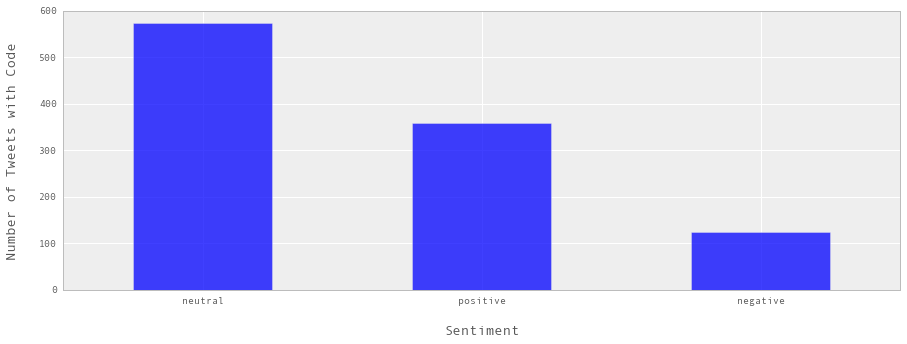

In [45]:
sentiment_plot = df['best_score'].value_counts().plot(kind='bar', alpha=0.75)
sentiment_plot.set_ylabel('Number of Tweets with Code', labelpad=20, fontsize=14)
sentiment_plot.set_xlabel('Sentiment', labelpad=20, fontsize=14)
xlabels = ['neutral', 'positive', 'negative']
sentiment_plot.set_xticklabels(xlabels, rotation='horizontal')

<br>For more Notebooks as well as additional Python and Big Data tutorials, please visit http://social-metrics.org or follow me on Twitter <a href='https://twitter.com/gregorysaxton'>@gregorysaxton</a><br>